# Persistence with fault tolerance
Here we create a workflow to check out the functionality of fault tolerance using persistence

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver                           # This is the tool that we will use to save the state permanently in the sqlite database as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict
import sqlite3
import time

This is for graphing purpose

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
llm = ChatOllama(model="llama3.1:8b")


## 3. Create a state

In [4]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 4. Define the function for the graph node

In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [6]:
def wait(state: JokeState):
    print("Sleeping for 30 seconds, manually crash the application")
    time.sleep(30)
    return state

In [7]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

## 5. Create the graph

In [8]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('wait', wait)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'wait')
graph.add_edge('wait', 'generate_explanation')
graph.add_edge('generate_explanation', END)

### Incorporate the checkpointer

In [ ]:
conn = sqlite3.connect(database="persistence_2.db", check_same_thread=False)           # This will create the DB in case it didnot exist earlier.
checkpointer = SqliteSaver(conn)

## 6. Compile the graph while incorporating the checkpointer

In [10]:
workflow = graph.compile(checkpointer=checkpointer)

## 7. The Graph

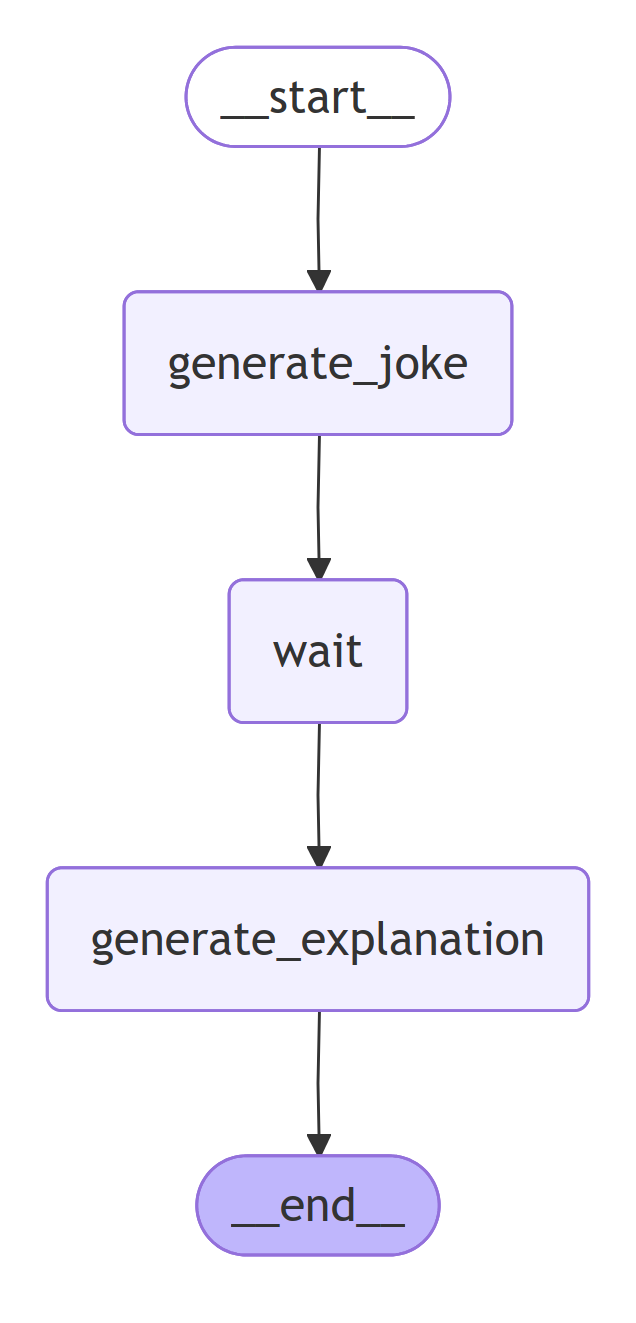

In [11]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 8. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [12]:
config1 = {"configurable": {"thread_id": "1"}}

## 9. Crash the code

In [13]:
# First Thread
try:
    final_state = workflow.invoke({'topic':'pizza'}, config=config1)
    print(final_state)
except KeyboardInterrupt:
    print("Interrupted (simulated crash)")

Sleeping for 30 seconds, manually crash the application
Interrupted (simulated crash)


## 10. Rerun the code from the checkpoint

In [14]:
final_state = workflow.invoke(None, config=config1)
print(final_state)

Sleeping for 30 seconds, manually crash the application
{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThe joke relies on wordplay to create humor. The phrase "feeling crusty" has a double meaning here. In everyday language, someone who is "feeling crusty" might be describing a person who is irritable or in a bad mood. However, the joke takes this expression literally by referencing the fact that a pizza has a crust – a characteristic part of its composition.\n\nThe punchline is funny because it subverts our expectation of what "feeling crusty" typically means. Instead of being a metaphor for a person\'s emotional state, it becomes a clever pun related to the pizza itself. The joke requires a quick mental shift to recognize the wordplay and appreciate the humor in it.'}


In [15]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThe joke relies on wordplay to create humor. The phrase "feeling crusty" has a double meaning here. In everyday language, someone who is "feeling crusty" might be describing a person who is irritable or in a bad mood. However, the joke takes this expression literally by referencing the fact that a pizza has a crust – a characteristic part of its composition.\n\nThe punchline is funny because it subverts our expectation of what "feeling crusty" typically means. Instead of being a metaphor for a person\'s emotional state, it becomes a clever pun related to the pizza itself. The joke requires a quick mental shift to recognize the wordplay and appreciate the humor in it.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2595-369f-67fa-8008-7d24a72a

In [16]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThe joke relies on wordplay to create humor. The phrase "feeling crusty" has a double meaning here. In everyday language, someone who is "feeling crusty" might be describing a person who is irritable or in a bad mood. However, the joke takes this expression literally by referencing the fact that a pizza has a crust – a characteristic part of its composition.\n\nThe punchline is funny because it subverts our expectation of what "feeling crusty" typically means. Instead of being a metaphor for a person\'s emotional state, it becomes a clever pun related to the pizza itself. The joke requires a quick mental shift to recognize the wordplay and appreciate the humor in it.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2595-369f-67fa-8008-7d24a72